In [17]:
#Load Akita Functions

import os
import json
import subprocess
import shutil
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU

import tensorflow as tf
print(tf.__version__)
if tf.__version__[0] == '1':
    tf.compat.v1.enable_eager_execution()

import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
from cooltools.lib.numutils import set_diag
import sys
sys.path.append("/wynton/home/hernandez/shirondru/pollard_lab/basenji")
from basenji import dataset, dna_io, seqnn

import cooler
import cooltools
from cooltools.lib.numutils import observed_over_expected
from cooltools.lib.numutils import adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons
from cooltools.lib.numutils import interp_nan, set_diag
from cooltools.lib.plotting import *


import kipoiseq
from kipoiseq import Interval
import pyfaidx
from collections import Counter

fasta_file = '/wynton/home/hernandez/shirondru/pollard_lab/data/hg38_genome.fa'



### load params, specify model ###

model_dir = '/wynton/home/hernandez/shirondru/pollard_lab/'
params_file = model_dir+'params.json'
model_file  = model_dir+'model_best.h5'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seqnn_model = seqnn.SeqNN(params_model)


### restore model ###
# note: run %%bash get_model.sh 
# if you have not already downloaded the model
seqnn_model.restore(model_file)
print('successfully loaded')


### names of targets ###
data_dir =   '/wynton/home/hernandez/shirondru/pollard_lab/basenji/manuscripts/akita/data/'

hic_targets = pd.read_csv(data_dir+'/targets.txt',sep='\t')
hic_file_dict_num = dict(zip(hic_targets['index'].values, hic_targets['file'].values) )
hic_file_dict     = dict(zip(hic_targets['identifier'].values, hic_targets['file'].values) )
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )

# read data parameters
data_stats_file = '%s/statistics.json' % data_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

### for converting from flattened upper-triangluar vector to symmetric matrix  ###

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T


def preprocess_from_cool(myseq_str, genome_hic_cool):
    print("Seq-str: ", myseq_str)
    num_counts= np.sum(genome_hic_cool.matrix(balance=False).fetch(myseq_str))
    seq_hic_obs = genome_hic_cool.matrix(balance=True).fetch(myseq_str)
    seq_hic_smoothed =  adaptive_coarsegrain(
                     seq_hic_obs,  
                     genome_hic_cool.matrix(balance=False).fetch(myseq_str),  
                     cutoff=3, max_levels=8)
    seq_hic_nan = np.isnan(seq_hic_smoothed)
    seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]
    seq_hic_obsexp = np.log(seq_hic_obsexp)
    seq_hic_obsexp = np.clip(seq_hic_obsexp,-2,2)
    seq_hic_obsexp_init = np.copy(seq_hic_obsexp)
    seq_hic_obsexp = interp_nan(seq_hic_obsexp)
    seq_hic_obsexp = np.nan_to_num(seq_hic_obsexp)
    seq_hic = np.clip(seq_hic_obsexp,-2,2)
    for i in [-1,0,1]: set_diag(seq_hic, 0,i)
        
    from astropy.convolution import Gaussian2DKernel
    from astropy.convolution import convolve
    kernel = Gaussian2DKernel(x_stddev=1,x_size=5)

    seq_hic = convolve(seq_hic, kernel)
    return seq_hic, num_counts, seq_hic_obs


def get_expt(region_chr, region_start, region_stop,genome_hic_cool,target_length_cropped):
    myseq_str = "{}:{}-{}".format(region_chr, region_start, region_stop)
    expt, num_counts, expt_obs = preprocess_from_cool(myseq_str, genome_hic_cool)
    new_start = int((target_length - target_length_cropped)/2)
    new_end = int(target_length-new_start)
    expt = expt[new_start:target_length-new_start, new_start:target_length-new_start]
    return(expt)


# @title `variant_centered_sequences`

class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)
    
  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#') or line.startswith('CHROM'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def get_N_composition(seq: str):
    """
    Get % of N's in input sequence
    
    Input: 
        seq: string of sequence
    Returns: % of Ns in input sequence
    """
    count = Counter(seq)
    
    for key, value in count.items():
        count[key] = round(value/len(seq)*100,2)
#     if 'N' in count.keys():
    if count['N'] > 0:
        return count['N']
    else:
        return 0 

def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    ref_N_composition = get_N_composition(reference)
    
    alternate = seq_extractor.extract(interval, [variant], anchor=center)
    alt_N_composition = get_N_composition(alternate)
    yield {'inputs': {'ref': dna_io.dna_1hot(reference),
                      'alt': dna_io.dna_1hot(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt,
                        'ref_N_composition':ref_N_composition,
                        'alt_N_composition':alt_N_composition}}
    
def msd(alternate_prediction, reference_prediction):
    
    #returns Mean squared difference between alt and ref predictions for each cell line
    return np.nanmean(np.square(alternate_prediction - reference_prediction),axis = 1).reshape(-1)

def max_diff(alternate_prediction, reference_prediction):
    #returns max difference between absolute value of alt and ref predictions for each cell line


    return np.max(abs(alternate_prediction - reference_prediction),axis = 1).reshape(-1)



def plot_variant(cell_type,hg38_chr,hg38_pos,hg38_wt,hg38_alt):
    """
    cell_type (int): 0-5. Same convenction as `hic_num_to_name_dict`
    hg38_wt (str): Nucleotide in reference
    hg38_alt: altered nucleotide
    """
    if cell_type == 0:
        cooler_file = '/wynton/home/hernandez/shirondru/pollard_lab/basenji/manuscripts/akita/data/coolers/HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool'
    elif cell_type == 1:
        cooler_file = '/wynton/home/hernandez/shirondru/pollard_lab/basenji/manuscripts/akita/data/coolers/H1hESC_hg38_4DNFI1O6IL1Q.mapq_30.2048.cool'
    elif cell_type == 2:
        cooler_file = '/wynton/home/hernandez/shirondru/pollard_lab/basenji/manuscripts/akita/data/coolers/GM12878_inSitu_MboI_all.hg38.2048.cool'

    elif cell_type == 3:
        cooler_file = '/wynton/home/hernandez/shirondru/pollard_lab/basenji/manuscripts/akita/data/coolers/IMR90_inSitu_MboI_all.hg38.2048.cool'
    elif cell_type == 4:
        pass
    
    genome_hic_cool = cooler.Cooler(cooler_file)
    myseq_str = hg38_chr+':'+str(hg38_pos)
    
    seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))
    
    #get predictions
    interval = Interval(hg38_chr,hg38_pos, hg38_pos)
    interval = interval.resize(seq_length)
    center = interval.center() - interval.start
    variant = kipoiseq.dataclasses.Variant(chrom = hg38_chr, pos=hg38_pos,
                                           ref=hg38_wt, alt=hg38_alt)

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)
    
    ref_1hot = dna_io.dna_1hot(reference)
    alt_1hot = dna_io.dna_1hot(alternate)
    
    ref_pred = seqnn_model.model.predict(np.expand_dims(ref_1hot,0))
    alt_pred = seqnn_model.model.predict(np.expand_dims(alt_1hot,0))
    
    print(f'ln MSD: {np.log(msd(alt_pred,ref_pred))}')
    print(f'ln Max Difference: {np.log(max_diff(alt_pred,ref_pred))}')
    

    #experimental map for this region
    hic_params = params['model']['head_hic']
    cropping = hic_params[5]['cropping']
    target_length = params_model['target_length']
    print(target_length)
    target_length_cropped = target_length - 2 * cropping
    target = get_expt(hg38_chr, hg38_pos - (seq_length//2), hg38_pos + (seq_length//2),genome_hic_cool,target_length_cropped) # get experimental data
    print(target)
    
    
    target_index = cell_type

    print(' ')
    print(myseq_str)

    


    plt.figure(figsize=(8,4))
    vmin=-2; vmax=2

    # plot pred
    plt.subplot(121) 
    mat = from_upper_triu(ref_pred[:,:,target_index], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('Predicted Reference-'+str(hic_num_to_name_dict[target_index]),y=1.15 )
    plt.ylabel(myseq_str)

    # # plot target 
    plt.figure(figsize=(8,4))
    plt.subplot(122) 
#     mat = from_upper_triu(test_target, target_length1_cropped, hic_diags)
    im = plt.matshow(target, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( 'Experimental Reference-'+str(hic_num_to_name_dict[target_index]),y=1.15)
    plt.tight_layout()
    plt.show()
    plt.close()

    #plot mutation
    plt.figure(figsize=(8,4))
    plt.subplot(221)
    mat = from_upper_triu(alt_pred[:,:,target_index], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( f'{hg38_chr} {hg38_pos} {hg38_wt}>{hg38_alt}-'+str(hic_num_to_name_dict[target_index]),y=1.15)

    
    
    #plot difference between ref and alt
    
    plt.figure(figsize=(8,4))
    plt.subplot(222)
    mat = from_upper_triu(alt_pred[:,:,target_index] - ref_pred[:,:,target_index], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( f'{hg38_chr} {hg38_pos} {hg38_wt}>{hg38_alt} ALT - REF -'+str(hic_num_to_name_dict[target_index]),y=1.15)

    
    
    plt.tight_layout()
    plt.show()

    
def msd(alternate_prediction, reference_prediction):

    #returns Mean squared difference between alt and ref predictions for each cell line
    return np.nanmean(np.square(alternate_prediction - reference_prediction),axis = 1).reshape(-1)

def max_diff(alternate_prediction, reference_prediction):
    #returns max difference between absolute value of alt and ref predictions for each cell line


    return np.max(abs(alternate_prediction - reference_prediction),axis = 1).reshape(-1)

2.4.1
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1048576, 4)] 0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1048576, 4), 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1048576, 4)   0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1048576, 4)   0           stochastic_shift[0][0]           
______________________________________________________________________________________

successfully loaded


In [19]:
def plot_variant_effect(cell_type,hg38_chr,hg38_pos,hg38_wt,hg38_alt):
    if cell_type == 0:
        cooler_file = '/wynton/home/hernandez/shirondru/pollard_lab/basenji/manuscripts/akita/data/coolers/HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool'
    elif cell_type == 1:
        cooler_file = '/wynton/home/hernandez/shirondru/pollard_lab/basenji/manuscripts/akita/data/coolers/H1hESC_hg38_4DNFI1O6IL1Q.mapq_30.2048.cool'
    elif cell_type == 2:
        cooler_file = '/wynton/home/hernandez/shirondru/pollard_lab/basenji/manuscripts/akita/data/coolers/GM12878_inSitu_MboI_all.hg38.2048.cool'

    elif cell_type == 3:
        cooler_file = '/wynton/home/hernandez/shirondru/pollard_lab/basenji/manuscripts/akita/data/coolers/IMR90_inSitu_MboI_all.hg38.2048.cool'
    elif cell_type == 4:
        pass

    genome_hic_cool = cooler.Cooler(cooler_file)
    myseq_str = hg38_chr+':'+str(hg38_pos)

    seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

    #get predictions
    interval = Interval(hg38_chr,hg38_pos, hg38_pos)
    interval = interval.resize(seq_length)
    center = interval.center() - interval.start
    variant = kipoiseq.dataclasses.Variant(chrom = hg38_chr, pos=hg38_pos,
                                           ref=hg38_wt, alt=hg38_alt)

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    ref_1hot = dna_io.dna_1hot(reference)
    alt_1hot = dna_io.dna_1hot(alternate)

    ref_pred = seqnn_model.model.predict(np.expand_dims(ref_1hot,0))
    alt_pred = seqnn_model.model.predict(np.expand_dims(alt_1hot,0))

    print(f'ln MSD: {np.log(msd(alt_pred,ref_pred))}')
    print(f'lnMax Difference: {np.log(max_diff(alt_pred,ref_pred))}')


    #experimental map for this region
    hic_params = params['model']['head_hic']
    cropping = hic_params[5]['cropping']
    target_length = params_model['target_length']
    print(target_length)
    target_length_cropped = target_length - 2 * cropping
    target = get_expt(hg38_chr, hg38_pos - (seq_length//2), hg38_pos + (seq_length//2),genome_hic_cool,target_length_cropped) # get experimental data
    print(target)


    #for plotting gene annotations
    trim_size = (interval.end -interval.start -  (448*2048))/2
    mat_start = interval.start + trim_size
    mat_end = interval.end - trim_size


    target_index = cell_type

    print(' ')
    print(myseq_str)




    plt.figure(figsize=(8,4))
    vmin=-2; vmax=2

    # plot pred
    plt.subplot(121) 
    mat = from_upper_triu(ref_pred[:,:,target_index], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('Predicted Reference-'+str(hic_num_to_name_dict[target_index]),y=1.15 )
    plt.ylabel(myseq_str)

    # # plot target 
    plt.subplot(122) 
    #     mat = from_upper_triu(test_target, target_length1_cropped, hic_diags)
    im = plt.matshow(target, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( 'Experimental Reference-'+str(hic_num_to_name_dict[target_index]),y=1.15)
    plt.tight_layout()
    plt.show()
    plt.close()

    #plot mutation
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    mat = from_upper_triu(alt_pred[:,:,target_index], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( f'{hg38_chr} {hg38_pos} {hg38_wt}>{hg38_alt}-'+str(hic_num_to_name_dict[target_index]),y=1.15)



    #plot difference between ref and alt

    plt.figure(figsize=(8,4))
    plt.subplot(122)
    mat = from_upper_triu(alt_pred[:,:,target_index] - ref_pred[:,:,target_index], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( f'{hg38_chr} {hg38_pos} {hg38_wt}>{hg38_alt} ALT - REF -'+str(hic_num_to_name_dict[target_index]),y=1.15)



    plt.figure(figsize=(8,4))
    plt.subplot(122)
    mat = from_upper_triu(alt_pred[:,:,target_index] - ref_pred[:,:,target_index], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=1, vmin=-1)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( f'{hg38_chr} {hg38_pos} {hg38_wt}>{hg38_alt} ALT - REF -'+str(hic_num_to_name_dict[target_index]),y=1.15)

    plt.figure(figsize=(8,4))
    plt.subplot(122)
    mat = from_upper_triu(alt_pred[:,:,target_index] - ref_pred[:,:,target_index], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=0.2, vmin=-0.2)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( f'{hg38_chr} {hg38_pos} {hg38_wt}>{hg38_alt} ALT - REF -'+str(hic_num_to_name_dict[target_index]),y=1.15)



    plt.tight_layout()
    plt.show()

In [6]:
my_preds = pd.read_csv("/wynton/home/hernandez/shirondru/pollard_lab/GWASPredictions/PsychENCODE_GWAS_Predictions/Akita/test/Akita_msd_predictions_PsychENCODEGWASLeadTagVariants_Variants_KatieG_formed_AkitaPreds.vcf.csv")
katie_preds = pd.read_csv("/wynton/home/hernandez/shirondru/pollard_lab/GWASPredictions/PsychENCODE_GWAS_Predictions/PsychENCODE_GWAS_scripts/test/data_for_tests/AkitaPreds_by_KatieG/AkitaPreds_by_KatieG.tsv",sep='\t')


In [7]:
my_preds

,chrom,pos,id,ref,alt,ref_N_composition,alt_N_composition,0_HFF,1_H1hESC,2_GM12878,3_IMR90,4_HCT116
0,chr12,11625742,NaN,C,CA,0,0,0.002737585222348571,0.0014946184819564223,0.0011183756869286299,0.002407270483672619,0.0008149592904374003
1,chrom,pos,id,ref,alt,ref_N_composition,alt_N_composition,0_HFF,1_H1hESC,2_GM12878,3_IMR90,4_HCT116
2,chr18,72144815,NaN,ATAAG,A,0,0,0.000933207746129483,0.001603547134436667,0.00035394722362980247,0.0006486634956672788,0.0002389061264693737
3,chr21,23833812,NaN,G,A,0,0,3.2816303008331715e-09,2.9987010652376966e-09,1.2151422090767028e-09,2.681577182528372e-09,9.259480959755706e-10
4,chr8,78004260,NaN,C,T,0,0,1.7118361483881017e-07,2.37298593219748e-07,6.760313908671378e-08,1.343234856676645e-07,4.75360302232275e-08
5,chr8,10479106,NaN,C,T,0,0,5.231182598208761e-08,3.2740718580726025e-08,2.0324980809505178e-08,4.44013394940157e-08,1.4544890625245444e-08


In [8]:
katie_preds

,Chr,Pos,Ref,Alt,Type,Fam,Pheno,SampleID,Consequence,SYMBOL,Gene,DISTANCE,NEAREST,gnomADg_AF,PolyPhen,MSE,correlation,SSI,index
1,chr12,11625742,C,CA,Indel,11526,control,11526.s1,intergenic_variant,.,.,.,ETV6,NaN,NaN,7.873615e-04,0.998894,0.972653,52506
2,chr18,72144815,ATAAG,A,Indel,13621,case,13621.p1,intergenic_variant,.,.,.,CBLN2,NaN,NaN,1.210094e-03,0.952091,0.847234,101613
3,chr21,23833812,G,A,SNV,11144,case,11144.p1,intergenic_variant,.,.,.,MRPL39,0.000032,NaN,3.282525e-09,1.000000,1.000000,138801
4,chr8,78004260,C,T,SNV,13944,control,13944.s1,intergenic_variant,.,.,.,PKIA,NaN,NaN,1.712043e-07,0.999998,0.999963,234700
5,chr8,10479106,C,T,SNV,14309,control,14309.s1,intron_variant&non_coding_transcript_variant,AC104964.1,ENSG00000253678,.,.,NaN,NaN,5.231323e-08,1.000000,0.999997,241988


In [24]:
np.log(0.002737585222348571)

-5.900679052872559

ln MSD: [-5.900679  -6.505884  -6.795878  -6.0292616 -7.1123724]
lnMax Difference: [-1.690631  -1.8562858 -2.2052839 -1.8335164 -2.415274 ]
512
Seq-str:  chr12:11101454-12150030


/wynton/home/hernandez/shirondru/pollard_lab/pollard_environment/lib64/python3.6/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/wynton/home/hernandez/shirondru/pollard_lab/pollard_environment/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/wynton/home/hernandez/shirondru/pollard_lab/pollard_environment/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


[]
 
chr12:11625742


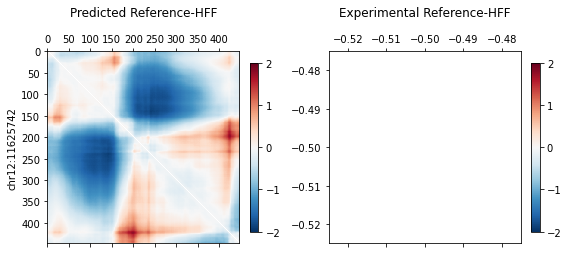

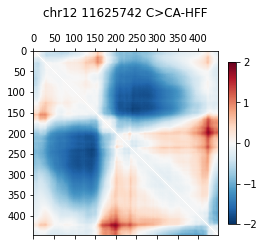

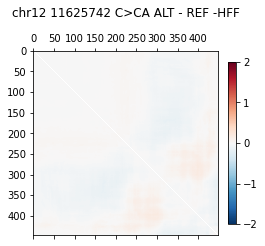

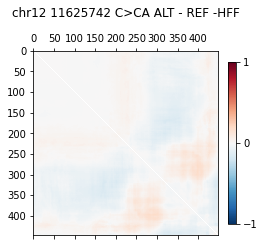

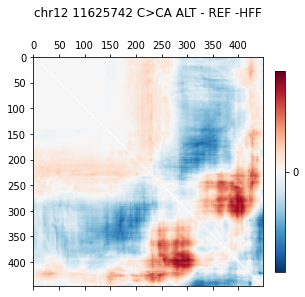

In [22]:
plot_variant_effect(0,'chr12',11625742,'C','CA')

In [11]:
0.002737585222348571/7.873615e-04

3.476910189726791